# Prácticas ESAC: Datos del JWST

1. Data
2. Radios de Strömgren
3. Histograms of $R_{HII}$ for all data
   
   Appendix A: Saving data \
   Appendix B: Función para calcualr $R_{HII}$ a partir de Ly$\alpha$

$\textit{Juan A. Molina-Calzada}$

In [13]:
# Packages
from astropy.table import Table, QTable, unique, vstack
from astropy.io import ascii
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import smplotlib
from uncertainties import ufloat, unumpy
import uncertainties.unumpy as unp
import sys

# Definimos Mpc en unidades propias comóviles
pMpc = u.def_unit('pMpc')
cMpc = u.def_unit('cMpc')

En este cuaderno vamos a trabajar con datos de galaxias a muy alto redshift detectadas recientemente por el JWST. En concreto, trabajaremos con los datos para un artículo del Science `data_science` y del Nature `data_nature`. 

## 1. Data

A continuación, exprotamos los datos. 

In [14]:
# Data: data_nature
data_science = {
    'ID': ['G2'],
    'z': [9.51],
    'e_z': [0.01],
    'F_Lya': [39*10**(-19)]*u.erg/u.s/(u.cm)**2,
    'EW_0': [31]*u.angstrom, 
    'log(M/Msun)': [7.63],
    'E_log(M/Msun)': [0.22],
    'e_log(M/Msun)': [0.24],
    'SFR':[1.69]*u.M_sun/u.yr,
    'E_SFR':[0.51]*u.M_sun/u.yr,
    'e_SFR':[0.34]*u.M_sun/u.yr,
    '12+log(0/H)': [7.48],
    'E_12+log(0/H)': [0.07],
    'e_12+log(0/H)': [0.05]
}

science = Table(data_science)
science

ID,z,e_z,F_Lya,EW_0,log(M/Msun),E_log(M/Msun),e_log(M/Msun),SFR,E_SFR,e_SFR,12+log(0/H),E_12+log(0/H),e_12+log(0/H)
,,,erg / (s cm2),Angstrom,,,,solMass / yr,solMass / yr,solMass / yr,,,
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
G2,9.51,0.01,3.9e-18,31.0,7.63,0.22,0.24,1.69,0.51,0.34,7.48,0.07,0.05


In [15]:
# Data: data_nature
data_nature = {
    'Source': [18924, 16155, 23920, 12899, 8613, 23619, 38335, 27335],
    'z': [7.70, 6.87, 6.00, 6.88, 6.38, 6.72, 6.23, 6.76],
    'SFR_Ha':[0.33, 0.92, 1.32, 0.49, 0.78, 0.85, 1.00, 0.73]*u.M_sun/u.yr,
    'e_SFR_Ha':[0.02, 0.04, 0.04, 0.02, 0.07, 0.07, 0.16, 0.10]*u.M_sun/u.yr,
    '12+log(0/H)': [6.95, 7.01, 6.84, 6.70, 6.97, 7.19, 7.46, 6.99],
    'e_12+log(0/H)': [0.15, 0.19, 0.06, 0.15, 0.18, 0.20, 0.32, 0.18],
    'log(M/Msun)': [5.88, 6.61, 6.30, 6.54, 7.12, 6.57, 6.83, 6.73],
    'E_log(M/Msun)': [0.13, 0.07, 0.03, 0.14, 0.07, 0.10, 0.25, 0.15],
    'e_log(M/Msun)': [0.08, 0.06, 0.03, 0.19, 0.08, 0.06, 0.20, 0.08]
}

nature = Table(data_nature)
nature

Source,z,SFR_Ha,e_SFR_Ha,12+log(0/H),e_12+log(0/H),log(M/Msun),E_log(M/Msun),e_log(M/Msun)
,,solMass / yr,solMass / yr,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64
18924,7.7,0.33,0.02,6.95,0.15,5.88,0.13,0.08
16155,6.87,0.92,0.04,7.01,0.19,6.61,0.07,0.06
23920,6.0,1.32,0.04,6.84,0.06,6.3,0.03,0.03
12899,6.88,0.49,0.02,6.7,0.15,6.54,0.14,0.19
8613,6.38,0.78,0.07,6.97,0.18,7.12,0.07,0.08
23619,6.72,0.85,0.07,7.19,0.2,6.57,0.1,0.06
38335,6.23,1.0,0.16,7.46,0.32,6.83,0.25,0.2
27335,6.76,0.73,0.1,6.99,0.18,6.73,0.15,0.08


## 2. Radios de Strömgren

En esta sección, vamos a calcular los radios de Strömgren por el método de Sobral y de Yajima nuevamente. Lo novedoso ahora es que estos datos contienen galaxias a redshift mas altos en comparación con los anteriores cuadernos. Sobretodo, nos es de interés aquella galaxia con z = 9.51. 

### 2.1. Radios de Strömgren using Sobral Relation

Para calcular el radio de Strömgren usando la relación de Sobral podemos reutilizar, adapatándola, la función que hemos implementado en cuadernos anteriores. La diferencia con como hemos hecho hasta ahora es que $\textbf{vamos a calcular el número de fotones ionizantes $\dot{N}_{ion}$ utilizando la línea de $H\alpha$ en lugar de}$ $\textbf{Ly$\alpha$}$. Esto es posible gracias a que los datos para estas galaxias han sido tomados por el JWST. 

El procedimiento para estimar el radio de Strömgren a partir de la tasa de formación estelar _SFR_, calculada utilizando como trazador la línea de H$\alpha$, es el siguiente. Partimos de,

$$
\begin{equation}
    SFR[M_\odot/yr] = 5.5 \cdot 10^{-42} \cdot L(H\alpha) [erg/s]
\end{equation}
$$

donde 

$$
\begin{equation}
    L(H\alpha) [erg/s] = 1.36 \cdot (1 - f_{esc,LyC}) \cdot 10^{-12} \cdot \dot{N} [photons/s]
\end{equation}
$$

donde asumiremos, dado el alto redshift, que la fracción de escape de fotones en el continuo es $f_{esc,LyC}$ = 0. Conocido $\dot{N} [photons/s]$, ya podemos obtener directamente el radio de Strömgren con la expresión general. 

In [16]:
def R_s_Ha(SFR_Ha, e_SFR_Ha,redshift):

    '''
    Strömgen radius calculation
    
    Values: [0]: star foramtion rate (calculated by Ha line)
            [1]: redshift
    Returns: [0]: Strömgen comovil radius
             [1]: Strömgen proper radius
             [2]: logN_ion (logaritmo en base 10 del número de fotones ionizantes; definciones de  Reionized-Bubble-published.pdf)
    
    Units: SFR_Ha in Msun/yr; redshift (adimensional)
    '''
    
    # recombination coefficinet for T_e = 10⁴K
    alphaB = 8.8 * 10**(-87)

    # C_H(z) parameter
    def C_H(redshift):
        z_values = [6 ,7 , 8]
        C_H_values = [2.37, 2.28, 2.19]
        C_H = np.interp(redshift, z_values,C_H_values) 
        return C_H

    # Hydrogen density
    def n_H (redshift):
        n_H = 5.878 * 10**66 * (1 + redshift)**3
        return n_H

    # Luminosity of Halpha
    L_Ha = SFR_Ha.value / (5.5 * 10**(-42))
    e_L_Ha = unumpy.uarray(SFR_Ha.value,e_SFR_Ha.value) / (5.5 * 10**(-42))
    e_L_Ha = unp.std_devs(e_L_Ha)

    # Number of ionizating photons
    f_esc = 0 # assuming 0 (escape fraction of ionizating photons / continuum)
    N_ion = L_Ha / (1.36 * (1 - f_esc) * 10**(-12))
    log_N_ion = np.log10(N_ion)
    e_log_N_ion = (e_L_Ha / (1.36 * 10**(-12))) / (np.log(10) * N_ion)

    # Strömgen radius (proper)
    R_s = (3 * N_ion / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB))**(1/3)
    e_R_s = 1/3 * (3 * (e_log_N_ion * np.log(10) * N_ion) / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB)) * (3 * (N_ion) / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB))**(-2/3)
    
    # Strömgen radius (comovil)
    R_s_com = (1 + redshift) * R_s
    e_R_s_com = (1 + redshift) * e_R_s
    
    return np.round(R_s,3) * pMpc, np.round(R_s_com,3) * cMpc, np.round(log_N_ion,3) * u.dex(1 / u.s), np.round(e_log_N_ion,3) * u.dex(1 / u.s), np.round(e_R_s,3) * pMpc, np.round(e_R_s_com,3) * cMpc 

Dada la función anterior, calculamos y ponemos los valores de los radios de Strömgren en las tablas de datos.

In [32]:
# Introducing RHII to nature
nature['R_s'] = R_s_Ha(nature['SFR_Ha'] ,nature['e_SFR_Ha'] ,nature['z'])[0]
nature['e_R_s'] = R_s_Ha(nature['SFR_Ha'] ,nature['e_SFR_Ha'] ,nature['z'])[4]
nature['R_s_com'] = R_s_Ha(nature['SFR_Ha'] ,nature['e_SFR_Ha'] ,nature['z'])[1]
nature['e_R_s_com'] = R_s_Ha(nature['SFR_Ha'] ,nature['e_SFR_Ha'] ,nature['z'])[5]
nature['logN_ion'] = R_s_Ha(nature['SFR_Ha'] ,nature['e_SFR_Ha'] ,nature['z'])[2]
nature['e_logN_ion'] = R_s_Ha(nature['SFR_Ha'] ,nature['e_SFR_Ha'] ,nature['z'])[3]
nature

Source,z,SFR_Ha,e_SFR_Ha,12+log(0/H),e_12+log(0/H),log(M/Msun),E_log(M/Msun),e_log(M/Msun),R_s,e_R_s,R_s_com,e_R_s_com,logN_ion,e_logN_ion
,,solMass / yr,solMass / yr,,,,,,pMpc,pMpc,cMpc,cMpc,dex(1 / s),dex(1 / s)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18924,7.7,0.33,0.02,6.95,0.15,5.88,0.13,0.08,0.33,0.007,2.874,0.058,52.645,0.026
16155,6.87,0.92,0.04,7.01,0.19,6.61,0.07,0.06,0.562,0.008,4.422,0.064,53.09,0.019
23920,6.0,1.32,0.04,6.84,0.06,6.3,0.03,0.03,0.792,0.008,5.545,0.056,53.247,0.013
12899,6.88,0.49,0.02,6.7,0.15,6.54,0.14,0.19,0.454,0.006,3.58,0.049,52.816,0.018
8613,6.38,0.78,0.07,6.97,0.18,7.12,0.07,0.08,0.601,0.018,4.435,0.133,53.018,0.039
23619,6.72,0.85,0.07,7.19,0.2,6.57,0.1,0.06,0.568,0.016,4.382,0.12,53.056,0.036
38335,6.23,1.0,0.16,7.46,0.32,6.83,0.25,0.2,0.679,0.036,4.908,0.262,53.126,0.069
27335,6.76,0.73,0.1,6.99,0.18,6.73,0.15,0.08,0.534,0.024,4.146,0.189,52.989,0.059


In [23]:
# Introducing RHII to science
science['R_s'] = R_s_Ha(science['SFR'] ,science['e_SFR'] ,science['z'])[0]
science['e_R_s'] = R_s_Ha(science['SFR'] ,science['e_SFR'] ,science['z'])[4]
science['E_R_s'] = R_s_Ha(science['SFR'] ,science['E_SFR'] ,science['z'])[4]
science['R_s_com'] = R_s_Ha(science['SFR'] ,science['e_SFR'] ,science['z'])[1]
science['e_R_s_com'] = R_s_Ha(science['SFR'] ,science['e_SFR'] ,science['z'])[5]
science['E_R_s_com'] = R_s_Ha(science['SFR'] ,science['E_SFR'] ,science['z'])[5]
science['logN_ion'] = R_s_Ha(science['SFR'] ,science['e_SFR'] ,science['z'])[2]
science['e_logN_ion'] = R_s_Ha(science['SFR'] ,science['e_SFR'] ,science['z'])[3]
science['E_logN_ion'] = R_s_Ha(science['SFR'] ,science['E_SFR'] ,science['z'])[3]
science

ID,z,e_z,F_Lya,EW_0,log(M/Msun),E_log(M/Msun),e_log(M/Msun),SFR,E_SFR,e_SFR,12+log(0/H),E_12+log(0/H),e_12+log(0/H),R_s,e_R_s,E_R_s,R_s_com,e_R_s_com,E_R_s_com,logN_ion,e_logN_ion,E_logN_ion
,,,erg / (s cm2),Angstrom,,,,solMass / yr,solMass / yr,solMass / yr,,,,pMpc,pMpc,pMpc,cMpc,cMpc,cMpc,dex(1 / s),dex(1 / s),dex(1 / s)
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
G2,9.51,0.01,3.9e-18,31.0,7.63,0.22,0.24,1.69,0.51,0.34,7.48,0.07,0.05,0.392,0.026,0.039,4.117,0.276,0.414,53.354,0.087,0.131


## 3. Histograms of $R_{HII}$ for all data

Por último, representamos un histograma de los radios de Strömgren calculados para todos los sets de datos que hemos trabajado en este cuaderno y todos los demas. 

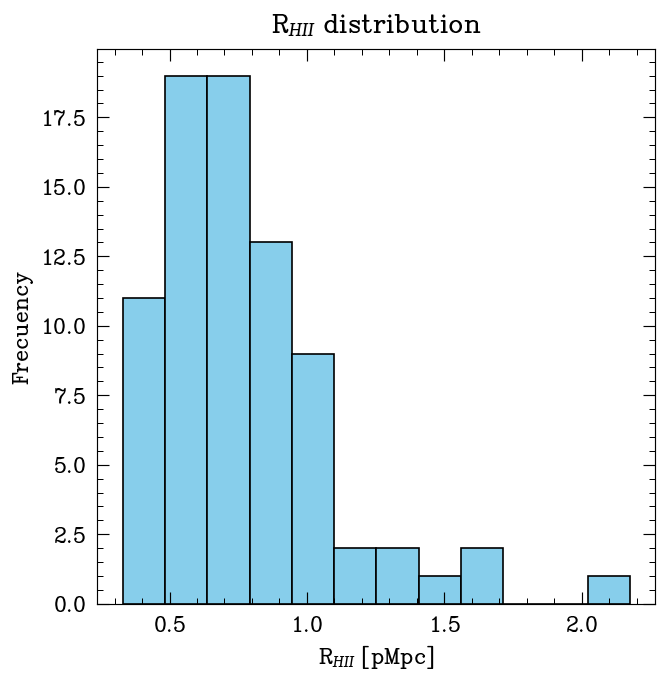

In [7]:
# Data
Kerutt22_filter_v1 = QTable.read('/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/stromgren_radius/Kerutt22_filter_v1.dat', format = 'ascii', delimiter = ' ')
Hu18_filter_v1 = QTable.read('/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/stromgren_radius/Hu18_filter_v1.dat', format = 'ascii', delimiter = ' ')
Jung20_filter_v1 = QTable.read('/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/stromgren_radius/Jung20_filter_v1.dat', format = 'ascii', delimiter = ' ')
Tilvi20_filter_v1 = QTable.read('/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/stromgren_radius/Tilvi20_filter_v1.dat', format = 'ascii', delimiter = ' ')

# Data from JWST
JWST_data = list(nature['R_s'].value) + list(science['R_s'].value)

# Histogram for all sample
all_data = np.concatenate([Kerutt22_filter_v1['R_s'].value,
                           Hu18_filter_v1['R_s'].value,
                           Jung20_filter_v1['R_s'].value,
                           Tilvi20_filter_v1['R_s'].value,
                           JWST_data]) # Strömgren radius calcualted by Sobral Relation

bins_fd = np.histogram_bin_edges(all_data, bins = 'fd')

fig, ax = plt.subplots()
ax.hist(all_data, bins = bins_fd, color = 'skyblue', edgecolor = 'black') 
ax.set_xlabel(r'R$_{HII}$ [pMpc]')
ax.set_ylabel('Frecuency')
ax.set_title('R$_{HII}$ distribution')

plt.show()

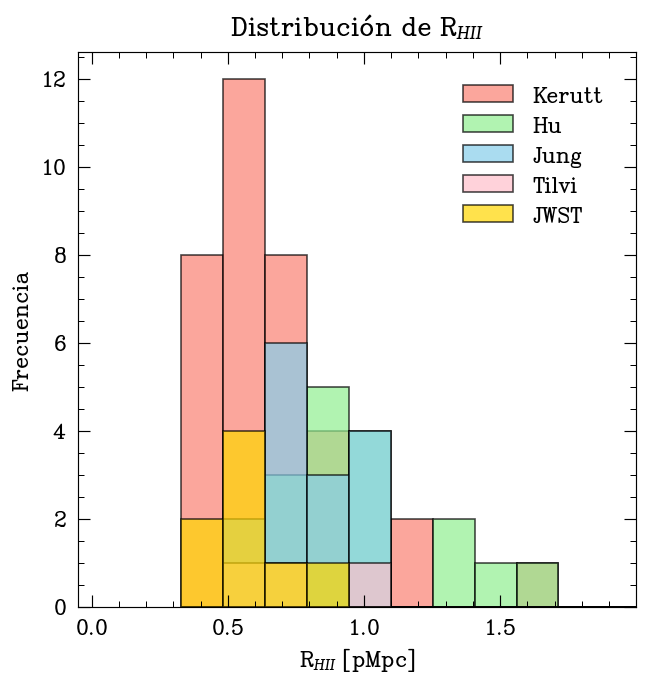

In [8]:
# Calcular los bins usando el método de Freedman-Diaconis
bins_fd = np.histogram_bin_edges(all_data, bins='fd')

# Configurar colores para cada conjunto de datos
colors = ['salmon', 'lightgreen', 'skyblue', 'pink','gold']
data_names = ['Kerutt', 'Hu', 'Jung', 'Tilvi','JWST']

# Crear el histograma
fig, ax = plt.subplots()
for i, data in enumerate([Kerutt22_filter_v1['R_s'].value,
                          Hu18_filter_v1['R_s'].value,
                          Jung20_filter_v1['R_s'].value,
                          Tilvi20_filter_v1['R_s'].value,
                          nature['R_s'].value]):
    ax.hist(data, bins=bins_fd, color=colors[i], edgecolor='black', alpha=0.7, label=data_names[i])

ax.set_xlabel(r'R$_{HII}$ [pMpc]')
ax.set_ylabel('Frecuencia')
ax.set_xlim(-0.05, 1.999)
ax.set_title('Distribución de R$_{HII}$')
ax.legend()

plt.show()

## Appendix A: Saving data

Si se ejecuta el siguiente código, guardaremos y sobreescribiremo los datos. Nótese que lo guardamos en formato ecsv (formato profesional para astrofísica)

In [9]:
ascii.write(science, 'science_data_v1.dat', format='ecsv', overwrite=True)  
ascii.write(nature, 'nature_data_v1.dat', format='ecsv', overwrite=True)  

In [30]:
# To LaTeX
data_table = ascii.read('science_data_v1.dat', format='ecsv')
df = data_table.to_pandas()
path = '/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/latex_tables/science.tex'
cols = ['ID', 'z', 'SFR', '12+log(0/H)', 'log(M/Msun)', 'R_s']
df.to_latex(buf=path ,columns= cols, float_format='%.2f',header=True, index=False, position= 'H', label = 'science', caption = 'science')

In [29]:
# To LaTeX
data_table = ascii.read('nature_data_v1.dat', format='ecsv')
df = data_table.to_pandas()
path = '/home/juanan/Escritorio/Juanan/Estudios/Master_en_Astrofisica/Practicas_ESAC/MyJob/latex_tables/nature.tex'
cols = ['Source', 'z', 'SFR_Ha', '12+log(0/H)', 'log(M/Msun)', 'R_s']
df.to_latex(buf=path ,columns= cols, float_format='%.2f',header=True, index=False, position= 'H', label = 'nature', caption = 'nature')

## Appendix B: Función para calcualr $R_{HII}$ a partir de Ly$\alpha$

En la siguiente celda nos guardamos las funciones `R_s_Ly` y `R_s_Ha` para calcular radios de Strömgren a partir de la línea de Ly$\alpha$ y H$\alpha$ respectivamente.

In [10]:
def R_s_Ly(EW, logLLya, redshift):

    '''
    Strömgen radius calculation
    
    Values: [0]: equivalent width (EW), 
            [1]: log10(observed luminosity of Lymann alpha)
            [2]: redshift
    Returns: [0]: Strömgen comovil radius
             [1]: Strömgen proper radius
             [2]: Sacape Lya fraction
             [3]: log10(intrisic luminosity of Lymann alpha)
             [4]: logQ_ion (según  las definciones de  Reionized-Bubble-published.pdf)
             [5]: EW (rest-frame)
             [6]: logN_ion (según  las definciones de  Reionized-Bubble-published.pdf)
    
    Units: EW in angstroms; logLLya in dex(erg/s); z (adimensional)
    '''

    # recombination coefficinet for T_e = 10⁴K
    alphaB = 8.8 * 10**(-87)

    # C_H(z) parameter
    def C_H(redshift):
        z_values = [6 ,7 , 8]
        C_H_values = [2.37, 2.28, 2.19]
        C_H = np.interp(redshift, z_values,C_H_values) 
        return C_H

    # Hydrogen density
    def n_H (redshift):
        n_H = 5.878 * 10**66 * (1+redshift)**3
        return n_H

    # Escape fraction of Lymann alpha (using Sobral Relation)
    f_esc_Lya = []

    for i in range(len(EW)):
        if 0 <= EW[i] <= 200:
            f_esc_Lya.append(0.0048*EW[i])
        else:
            f_esc_Lya.append(1)

    # log10(intrisic luminosity of Lymann alpha)
    logLLya_int = np.log10(10**logLLya/f_esc_Lya)

    # Effective number of ionizinz continuum photones per second
    logQ_ion = np.log10(10**logLLya_int / (1.19*10**(-11)))

    # Nuber of ionizing continuum photones that participate in reionizing the IGM
    f_esc_LyC = 0.2 # assumed f_esc_LyC
    N_ion = (10**logQ_ion) / (1 - f_esc_LyC) * f_esc_LyC

    # Strömgen radius (proper)
    R_s = (3 * N_ion / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB))**(1/3)

    # Strömgen radius (comovil)
    R_s_com = (1 + redshift) * R_s
    
    return np.round(R_s,3) * pMpc, np.round(R_s_com,3) * cMpc, np.round(f_esc_Lya,3), np.round(logLLya_int,3) * u.dex(u.erg / u.s), np.round(logQ_ion,3)  * u.dex(1 / u.s), np.round(EW,2)  * u.angstrom, np.round(np.log10(N_ion),3) * u.dex(1 / u.s)

In [11]:
def R_s_Ha(SFR_Ha, redshift):

    '''
    Strömgen radius calculation
    
    Values: [0]: star foramtion rate (calculated by Ha line)
            [1]: redshift
    Returns: [0]: Strömgen comovil radius
             [1]: Strömgen proper radius
             [2]: logN_ion (logaritmo en base 10 del número de fotones ionizantes; definciones de  Reionized-Bubble-published.pdf)
    
    Units: SFR_Ha in Msun/yr; redshift (adimensional)
    '''
    
    # recombination coefficinet for T_e = 10⁴K
    alphaB = 8.8 * 10**(-87)

    # C_H(z) parameter
    def C_H(redshift):
        z_values = [6 ,7 , 8]
        C_H_values = [2.37, 2.28, 2.19]
        C_H = np.interp(redshift, z_values,C_H_values) 
        return C_H

    # Hydrogen density
    def n_H (redshift):
        n_H = 5.878 * 10**66 * (1 + redshift)**3
        return n_H

    # Luminosity of Halpha
    L_Ha = SFR_Ha.value / (5.5 * 10**(-42))

    # Number of ionizating photons
    f_esc = 0 # assuming 0 (escape fraction of ionizating photons / continuum)
    N_ion = L_Ha / (1.36 * (1 - f_esc) * 10**(-12))
    log_N_ion = np.log10(N_ion)

    # Strömgen radius (proper)
    R_s = (3 * N_ion / (4 * np.pi * C_H(redshift) * n_H(redshift)**2 * alphaB))**(1/3)

    # Strömgen radius (comovil)
    R_s_com = (1 + redshift) * R_s
    
    return np.round(R_s,3) * pMpc, np.round(R_s_com,3) * cMpc, np.round(log_N_ion,3) * u.dex(1 / u.s)